In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    fh = open(graph_path+str(file)+".txt", "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(nx.relabel_nodes(GRAPH, map))  
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(env, action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid): 
    if grid[0] * grid[1] < 10:
        figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(12, 10))
    else :
        figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(22, 20))
    AUC  = []
    NodeRemoved = []
    model_name = ["MIX","BA","FINDER","CI","COREHD"]
    for i, graph_name in enumerate(file_list):
        GRAPH, map = input_graph(graph_path,graph_name)
        N = len(GRAPH)
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions_CI = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions_CoreHD =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''

        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_CI,auc_CoreHD],dtype='O')
        actions_all = [actions_mix,actions_ba,actions_Finder,actions_CI,actions_CoreHD]
        fractionNode = np.array([len(xi) for xi in actions_all],dtype='O')/N
        AUC.append(np.insert(auc_all,0,graph_name))
        NodeRemoved.append(np.insert(fractionNode,0,graph_name))
        print("AUC",graph_name,model_name[np.argmin(np.array(auc_all,dtype='O'))],np.amin(np.array(auc_all,dtype='O')))
        print("FRACTION",graph_name,model_name[np.argmin(np.array(fractionNode ,dtype='O'))],np.amin(np.array(fractionNode ,dtype='O')))
        print()
    AUC = np.array(AUC)
    np.savetxt("./Figure/Compiled/HDA/AUC_"+title+".csv", AUC,delimiter=" & ",newline = "\\\\ \n", fmt=('%s','%f','%f','%f','%f','%f')) 
    NodeRemoved = np.array(NodeRemoved)
    np.savetxt("./Figure/Compiled/HDA/Removed_"+title+".csv", NodeRemoved,delimiter=" & ",newline = "\\\\ \n",fmt=('%s','%f','%f','%f','%f','%f')) 
    figure.text(0.5, 0.03,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.04, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    plt.savefig("./Figure/Compiled/HDA/"+title+".pdf")
    plt.show()

# Synthetic Network:- Heterogeneity and Homogeneity

heterogeneous_30
[3, 13, 20, 15, 2, 21, 10]
[8, 10, 15, 2, 21, 3, 12]
AUC heterogeneous_30 FINDER 3.978260869565217
FRACTION heterogeneous_30 MIX 0.30434782608695654
heterogeneous_50
[3, 11, 12, 29, 26, 10, 16, 22, 25, 6]
[11, 12, 35, 25, 10, 3, 16, 22, 26, 31, 6]
AUC heterogeneous_50 MIX 5.694444444444445
FRACTION heterogeneous_50 MIX 0.2777777777777778
heterogeneous_100
[74, 54, 9, 71, 31, 50, 11, 29, 35, 30, 1, 13, 48, 45]
[74, 54, 31, 35, 71, 9, 14, 13, 50, 30, 11, 1, 58, 57, 48, 29]
AUC heterogeneous_100 CI 8.322368421052632
FRACTION heterogeneous_100 MIX 0.18421052631578946
heterogeneous_500
[411, 407, 245, 103, 154, 150, 98, 109, 263, 148, 198, 152, 261, 363, 195, 254, 225, 214, 253, 260, 380, 306, 197, 281, 173, 278, 1, 338, 352, 252, 112, 286, 18, 219, 45, 107, 136, 130, 104, 129, 275, 398, 247, 34, 243, 251, 2, 133, 28, 279, 244, 264, 32, 256, 88, 383, 240, 42, 91]
[407, 411, 97, 103, 109, 198, 154, 171, 150, 245, 263, 279, 148, 260, 195, 98, 152, 363, 261, 380, 275, 306, 253

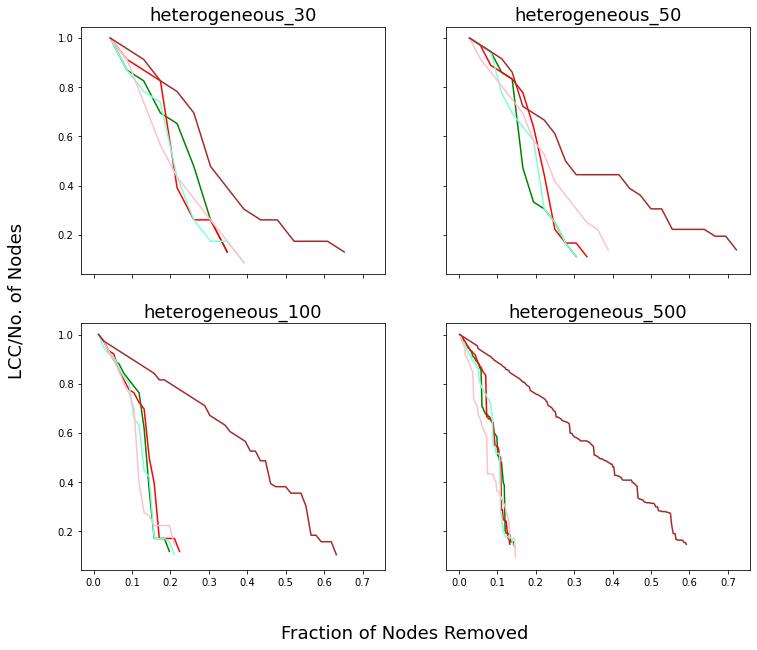

In [9]:
#BA 474500 #Homo 59000 #Hetero 348500#Tree 476000#
#BA 429000 # Homo 461500 #Hetero 5000 #Tree 1000 #
BA = 348500
MIX = 5000 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"heterogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])



homogeneous_30
[17, 26, 4, 24, 1, 3, 2, 22, 23, 21, 12, 7]
[17, 26, 3, 1, 24, 2, 4, 22, 23, 21, 7]
AUC homogeneous_30 FINDER 5.672413793103449
FRACTION homogeneous_30 FINDER 0.3448275862068966
homogeneous_50
[47, 33, 1, 19, 23, 2, 40, 4, 35, 20, 29, 21, 34, 30, 3, 5]
[33, 47, 1, 23, 19, 2, 40, 35, 4, 29, 3, 20, 34, 30, 5]
AUC homogeneous_50 CI 7.59
FRACTION homogeneous_50 FINDER 0.24
homogeneous_100
[64, 89, 63, 10, 13, 0, 49, 79, 6, 8, 14, 67, 77, 7, 85, 15, 78, 5, 60, 21, 29]
[64, 89, 78, 13, 10, 63, 5, 60, 4, 49, 61, 7, 59, 77, 6, 21, 29, 8, 85, 3, 67]
AUC homogeneous_100 FINDER 12.335106382978722
FRACTION homogeneous_100 MIX 0.22340425531914893
homogeneous_500
[465, 459, 63, 138, 61, 223, 88, 3, 404, 26, 412, 452, 190, 417, 1, 461, 114, 178, 272, 57, 204, 415, 167, 149, 135, 414, 345, 227, 284, 125, 384, 124, 438, 96, 374, 270, 137, 455, 2, 162, 25, 78, 372, 100, 188, 373, 50, 463, 371, 327, 219, 196, 233, 222, 170, 431, 60, 205, 252, 254, 98, 376, 450, 21, 164, 174, 207, 273, 165,

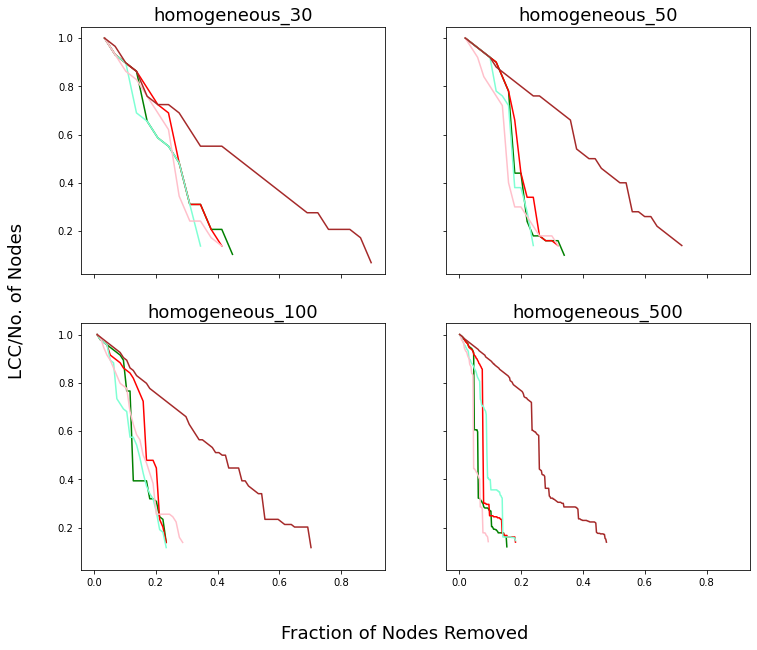

In [10]:
BA = 59000 
MIX =461500
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"homogeneous",[[0,0],[0,1],[1,0],[1,1]],[2,2])

# Synthetic with Motifs Attached

In [15]:
BA = 474500 
MIX = 429000
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


AUC ba_300_20_house_1 CI 75.61375000000002
FRACTION ba_300_20_house_1 BA 0.26

AUC ba_300_40_house_2 CI 77.70899999999999
FRACTION ba_300_40_house_2 CI 0.24

AUC ba_300_60_house_3 CI 77.84166666666667
FRACTION ba_300_60_house_3 CI 0.19833333333333333

AUC ba_300_80_house_4 CI 76.97857142857144
FRACTION ba_300_80_house_4 CI 0.17142857142857143

AUC ba_300_100_house_5 CI 79.701875
FRACTION ba_300_100_house_5 BA 0.15625

AUC ba_300_20_fan_1 CI 82.9234375
FRACTION ba_300_20_fan_1 BA 0.353125

AUC ba_300_40_fan_2 CI 79.63676470588236
FRACTION ba_300_40_fan_2 BA 0.3382352941176471

AUC ba_300_60_fan_3 CI 80.98055555555555
FRACTION ba_300_60_fan_3 BA 0.33055555555555555

AUC ba_300_80_fan_4 CI 79.81447368421053
FRACTION ba_300_80_fan_4 BA 0.3078947368421053

AUC ba_300_100_fan_5 CI 77.00374999999998
FRACTION ba_300_100_fan_5 BA 0.285

AUC ba_300_20_clique_1 CI 76.78073089700995
FRACTION ba_300_20_clique_1 BA 0.3521594684385382

AUC ba_300_40_clique_2 FINDER 86.28073089700996
FRACTION ba_300_4

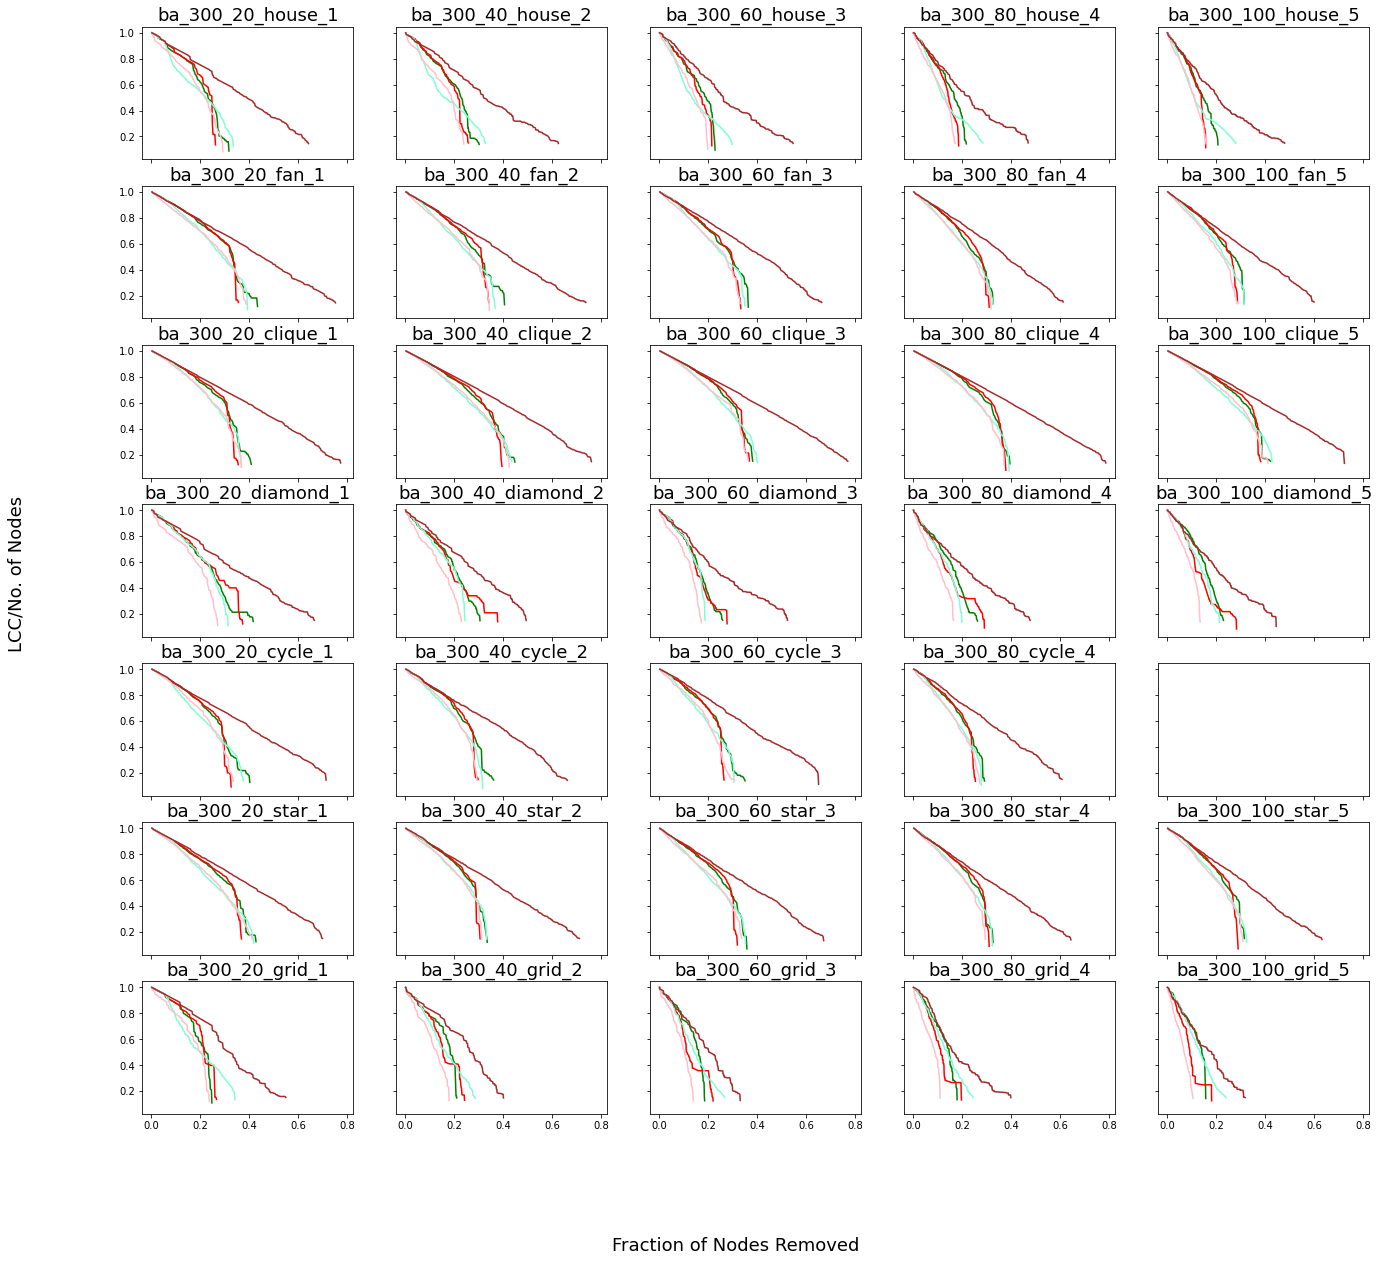

In [17]:
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5

grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


In [18]:
BA = 476000
MIX = 1000
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


AUC tree_8_20_house_1 CI 29.814238952536822
FRACTION tree_8_20_house_1 CI 0.06873977086743044

AUC tree_8_40_house_2 CI 39.904360056258795
FRACTION tree_8_40_house_2 CI 0.08016877637130802

AUC tree_8_60_house_3 CI 44.79963008631319
FRACTION tree_8_60_house_3 BA 0.08877928483353884

AUC tree_8_80_house_4 CI 59.02689352360044
FRACTION tree_8_80_house_4 CI 0.10867178924259056

AUC tree_8_100_house_5 CI 56.9055390702275
FRACTION tree_8_100_house_5 BA 0.08704253214638971

AUC tree_8_20_fan_1 CI 29.134651600753298
FRACTION tree_8_20_fan_1 CI 0.08097928436911488

AUC tree_8_40_fan_2 BA 24.85934664246824
FRACTION tree_8_40_fan_2 BA 0.06715063520871144

AUC tree_8_60_fan_3 BA 30.780210157618214
FRACTION tree_8_60_fan_3 FINDER 0.08231173380035026

AUC tree_8_80_fan_4 BA 31.98900169204738
FRACTION tree_8_80_fan_4 MIX 0.08460236886632826

AUC tree_8_100_fan_5 BA 31.92144026186579
FRACTION tree_8_100_fan_5 BA 0.07692307692307693

AUC tree_8_20_clique_1 MIX 26.3876953125
FRACTION tree_8_20_clique_1

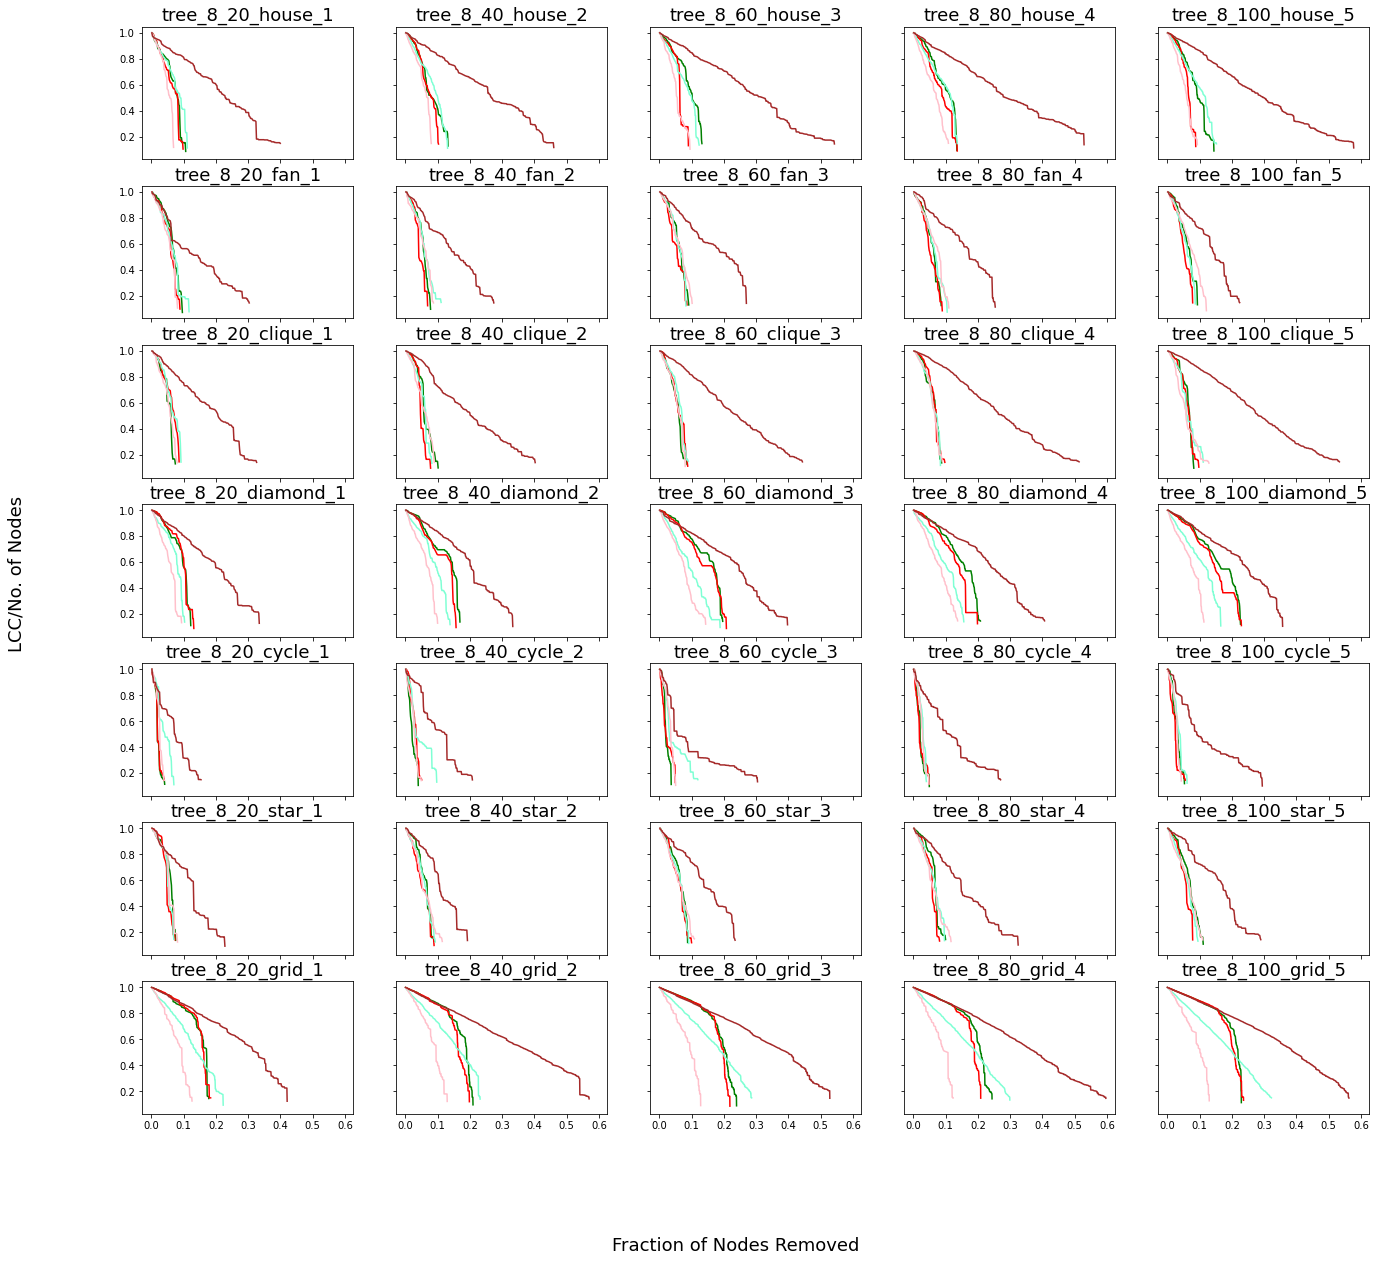

In [19]:
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


# Real World Dataset

AUC corruption FINDER 13.432038834951456
FRACTION corruption MIX 0.06472491909385113

AUC foodweb-baywet CI 46.4296875
FRACTION foodweb-baywet CI 0.5625

AUC inf-USAir97 CI 33.92620481927711
FRACTION inf-USAir97 BA 0.17771084337349397

AUC moreno_crime_projected CI 16.446949602122015
FRACTION moreno_crime_projected CI 0.050397877984084884

AUC opsahl-openflights CI 179.93228989452194
FRACTION opsahl-openflights CI 0.10547805375978224

AUC household CI 91.96634093376764
FRACTION household BA 0.1758957654723127

AUC faa CI 106.24184339314846
FRACTION faa CI 0.13376835236541598

AUC facebook FINDER 1.8829639889196677
FRACTION facebook MIX 0.0017313019390581717

AUC powergrid CI 173.17233353572152
FRACTION powergrid CI 0.060109289617486336

AUC netscience CI 2.829911019849418
FRACTION netscience CI 0.019164955509924708

AUC HI-II-14 CI 210.8194477791116
FRACTION HI-II-14 CI 0.09555822328931572



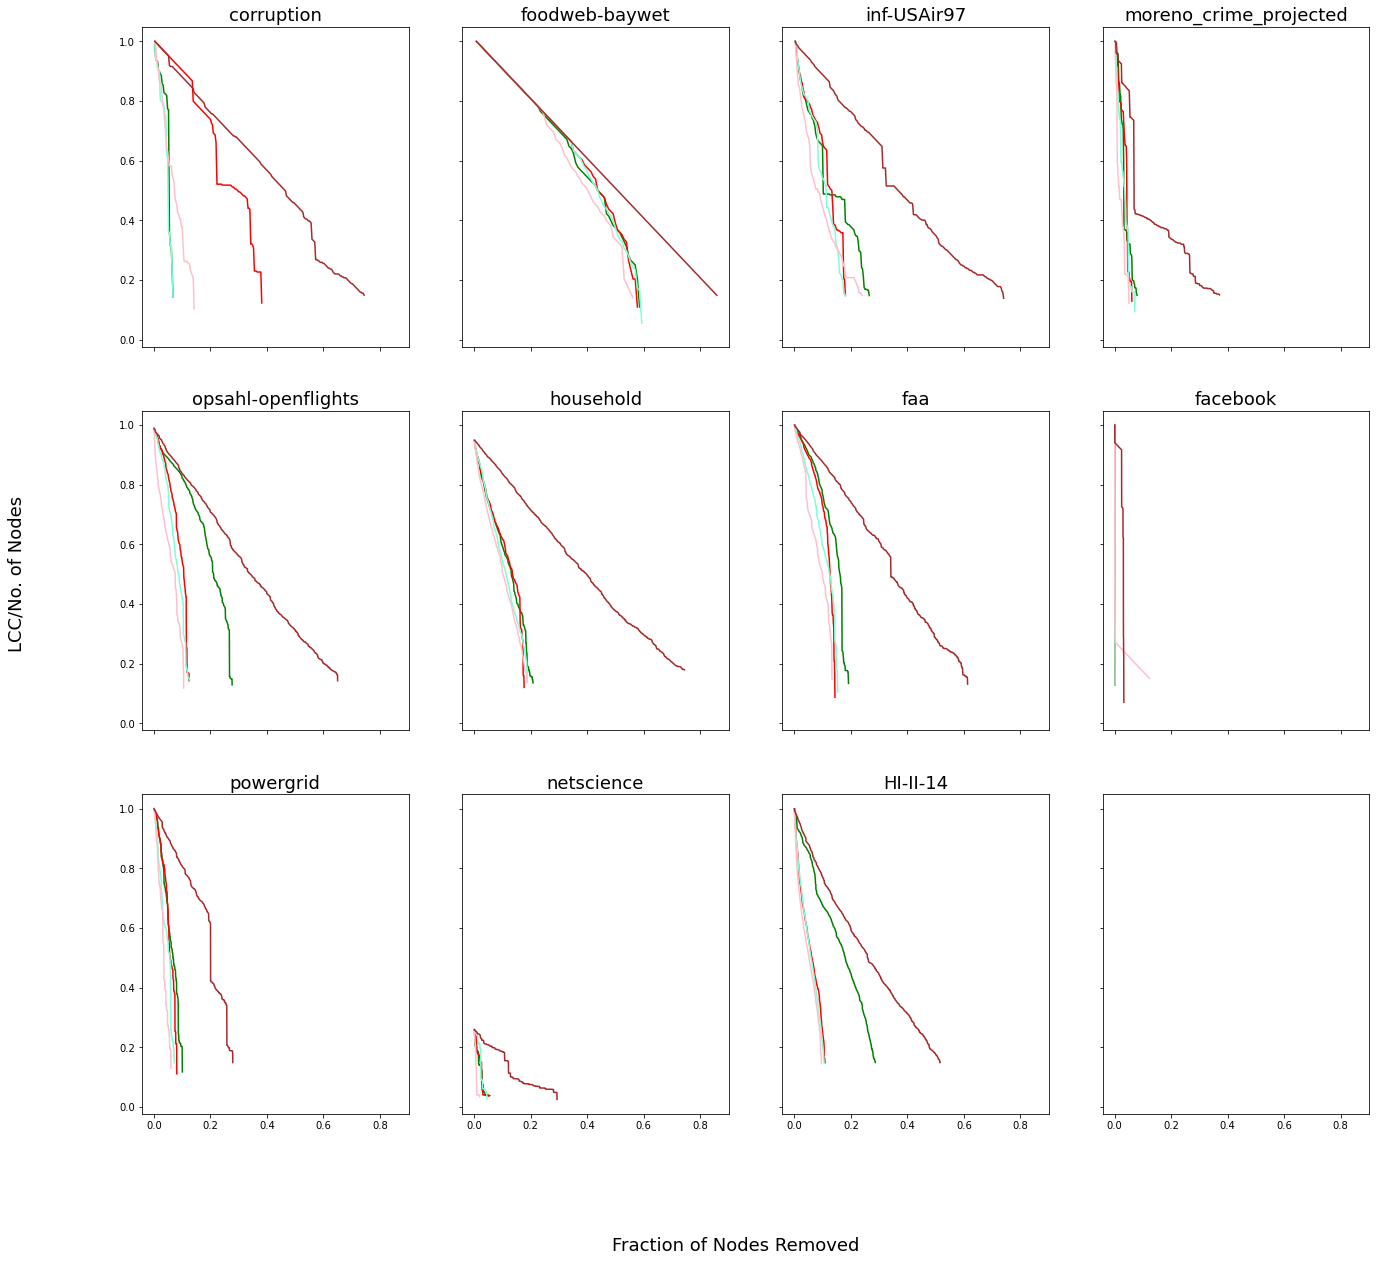

In [20]:
BA = 474500 
MIX = 429000
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]

file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14']
graph_path =  "./Dataset/Real/"
x, y = 3, 4
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Real",grid_plot,[x,y])


## Cancer Gene

In [ ]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 2, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])